## Neural networks for segmentation

In [1]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

import os
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

import time

# Augmentations from the Albumentations package
import cv2
from albumentations.pytorch import ToTensor
from albumentations import (
    Compose,
    RandomRotate90,
    Flip
)

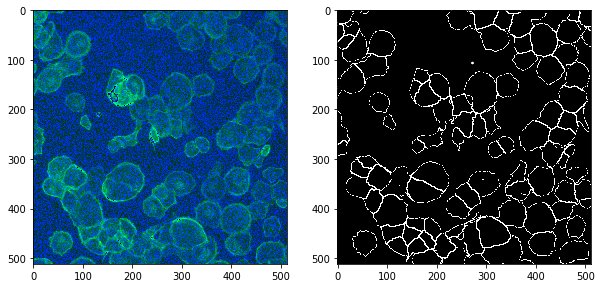

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

### Let's do it!
For a very long time UNet was a mistery for me, and I never had a chance to implement it. For this task I would be happy to do it. Thanks for the task!

That's how vanilla UNet architecture looks like:

![](unet.png "Title")

First question: what is the shape of the image? We want to pass the image through the U-shaped net, and get an image of the same shape in the end.

In [5]:
im.shape

(512, 512, 3)

### Define the model

~~I will try to implement the vanilla unet, and in the next section add BatchNorms, and other useful things. Well, there is an immediate modification. Our images comes in 3 channels, while the one in the paper was a black/white one (one channel). Also, my image want decrease in height/width during the pass because my convolutional layers have the `same` padding.~~

I started with vanilla unet, and then moved on and introduced augmentations and other stuff.

In [6]:
class UNETop(nn.Module):
    
    def __init__(self):
        super(UNETop, self).__init__()
        
        vgg11_bn = torch.hub.load('pytorch/vision:v0.5.0', 'vgg11_bn', pretrained=True)
        conv1_1 = vgg11_bn.features[0]
        bn1_1   = vgg11_bn.features[1]
        relu1_1 = vgg11_bn.features[2]
        
        conv2_1 = vgg11_bn.features[4]
        bn2_1   = vgg11_bn.features[5]
        relu2_1 = vgg11_bn.features[6]
        maxpool2_1 = vgg11_bn.features[7]
        conv3_1 = vgg11_bn.features[8]
        bn3_1   = vgg11_bn.features[9]
        relu3_1 = vgg11_bn.features[10]

        conv3_2 = vgg11_bn.features[11]
        bn3_2   = vgg11_bn.features[12]
        relu3_2 = vgg11_bn.features[13]
        maxpool4_1 = vgg11_bn.features[14]
        conv4_1 = vgg11_bn.features[15]
        bn4_1   = vgg11_bn.features[16]
        relu4_1 = vgg11_bn.features[17]

        conv4_2 = vgg11_bn.features[18]
        bn4_2   = vgg11_bn.features[19]
        relu4_2 = vgg11_bn.features[20]
        maxpool5_1 = vgg11_bn.features[21]
        
        self.x1 = nn.Sequential()
        self.x1.add_module('conv1_1', conv1_1)
        self.x1.add_module('bn1_1', bn1_1)
        self.x1.add_module('relu1_1', relu1_1)
        self.x1.add_module('conv1_2', nn.Conv2d(64, 64, kernel_size=(3,3), stride = 1, padding = 1))
        self.x1.add_module('bn1_2', nn.BatchNorm2d(64))
        self.x1.add_module('relu1_2', nn.ReLU())
        
        self.x2 = nn.Sequential()
        self.x2.add_module('maxpool2_1', maxpool2_1)
        self.x2.add_module('conv2_1', conv2_1)
        self.x2.add_module('bn2_1', bn2_1)
        self.x2.add_module('relu2_1', relu2_1)
        self.x2.add_module('conv2_2', nn.Conv2d(128, 128, kernel_size=(3,3), stride = 1, padding = 1))
        self.x2.add_module('bn2_2', nn.BatchNorm2d(128))
        self.x2.add_module('relu2_2', nn.ReLU())
        
        self.x3 = nn.Sequential()
        self.x3.add_module('maxpool3_1', nn.MaxPool2d(2))
        self.x3.add_module('conv3_1', conv3_1)
        self.x3.add_module('bn3_1', bn3_1)
        self.x3.add_module('relu3_1', relu3_1)
        self.x3.add_module('conv3_2', conv3_2)
        self.x3.add_module('bn3_2', bn3_2)
        self.x3.add_module('relu3_2', relu3_2)
        
        self.x4 = nn.Sequential()
        self.x4.add_module('maxpool4_1', maxpool4_1)
        self.x4.add_module('conv4_1', conv4_1)
        self.x4.add_module('bn4_1', bn4_1)
        self.x4.add_module('relu4_1', relu4_1)
        self.x4.add_module('conv4_2', conv4_2)
        self.x4.add_module('bn4_2', bn4_2)
        self.x4.add_module('relu4_2', relu4_2)
        
        self.x5 = nn.Sequential()
        self.x5.add_module('maxpool5_1', maxpool5_1)
        self.x5.add_module('conv5_1', nn.Conv2d(512, 1024, kernel_size=(3,3), stride = 1, padding = 1))
        self.x5.add_module('bn5_1', nn.BatchNorm2d(1024))
        self.x5.add_module('relu5_1', nn.ReLU())
        self.x5.add_module('conv5_2', nn.Conv2d(1024, 1024, kernel_size=(3,3), stride = 1, padding = 1))
        self.x5.add_module('bn5_2', nn.BatchNorm2d(1024))
        self.x5.add_module('relu5_2', nn.ReLU())

        self.x6 = nn.Sequential()
        self.x6.add_module('conv6_1', nn.Conv2d(1024, 512, kernel_size=(3,3), stride = 1, padding = 1))
        self.x6.add_module('bn6_1', nn.BatchNorm2d(512))
        self.x6.add_module('relu6_1', nn.ReLU())
        self.x6.add_module('conv6_2', nn.Conv2d(512, 256, kernel_size=(3,3), stride = 1, padding = 1))
        self.x6.add_module('relu6_2', nn.ReLU())
        self.x6.add_module('bn6_2', nn.BatchNorm2d(256))

        self.x7 = nn.Sequential()
        self.x7.add_module('conv7_1', nn.Conv2d(768, 384, kernel_size=(3,3), stride = 1, padding = 1))
        self.x7.add_module('bn7_1', nn.BatchNorm2d(384))
        self.x7.add_module('relu7_1', nn.ReLU())
        self.x7.add_module('conv7_2', nn.Conv2d(384, 256, kernel_size=(3,3), stride = 1, padding = 1))
        self.x7.add_module('bn7_2', nn.BatchNorm2d(256))
        self.x7.add_module('relu7_2', nn.ReLU())

        self.x8 = nn.Sequential()
        self.x8.add_module('conv8_1', nn.Conv2d(512, 256, kernel_size=(3,3), stride = 1, padding = 1))
        self.x8.add_module('bn8_1', nn.BatchNorm2d(256))
        self.x8.add_module('relu8_1', nn.ReLU())
        self.x8.add_module('conv8_2', nn.Conv2d(256, 128, kernel_size=(3,3), stride = 1, padding = 1))
        self.x8.add_module('bn8_2', nn.BatchNorm2d(128))
        self.x8.add_module('relu8_2', nn.ReLU())

        self.x9 = nn.Sequential()
        self.x9.add_module('conv9_1', nn.Conv2d(256, 128, kernel_size=(3,3), stride = 1, padding = 1))
        self.x9.add_module('bn9_1', nn.BatchNorm2d(128))
        self.x9.add_module('relu9_1', nn.ReLU())
        self.x9.add_module('conv9_2', nn.Conv2d(128, 64, kernel_size=(3,3), stride = 1, padding = 1))
        self.x9.add_module('bn9_2', nn.BatchNorm2d(64))
        self.x9.add_module('relu9_2', nn.ReLU())
        self.x9.add_module('conv9_3', nn.Conv2d(64, 1, kernel_size=(1,1), stride = 1, padding = 0))
    
    def forward(self, x):
        
        x1 = self.x1(x)  # -> bs x 64 x 512 x 512
        x2 = self.x2(x1) # -> bs x 128 x 256 x 256 
        x3 = self.x3(x2) # -> bs x 256 x 128 x 128 
        x4 = self.x4(x3) # -> bs x 512 x 64 x 64
        x5 = self.x5(x4) # -> bs x 1024 x 32 x 32
        x5 = F.interpolate(x5, scale_factor = 2) # -> bs x 1024 x 64 x 64
        x6 = self.x6(x5) # -> bs x 256 x 64 x 64
        x6 = torch.cat([x6, x4], dim=1) # -> bs x 768 x 64 x 64
        x6 = F.interpolate(x6, scale_factor = 2) # -> bs x 768 x 128 x 128
        x7 = self.x7(x6) # -> bs x 256 x 128 x 128
        x7 = torch.cat([x7, x3], dim=1) # -> bs x 512 x 128 x 128
        x7 = F.interpolate(x7, scale_factor = 2) # -> bs x 512 x 256 x 256
        x8 = self.x8(x7) # -> bs x 128 x 256 x 256
        x8 = torch.cat([x8, x2], dim=1) # -> bs x 256 x 256 x 256
        x9 = F.interpolate(x8, scale_factor = 2) # -> bs x 256 x 512 x 512
        out = self.x9(x9)
        return out

In [7]:
class SegmDataset(Dataset):
    def __init__(self, img_folder, mask_folder = None, transform=None):
        
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.img_folder))
    
    def __getitem__(self, idx):
        
        imgs = sorted(os.listdir(self.img_folder))
        this_img = imgs[idx]
        img_path = os.path.join(self.img_folder, this_img)
        image = skimage.img_as_ubyte(skimage.io.imread(img_path))        

        if self.mask_folder:
            masks = sorted(os.listdir(self.mask_folder))
            this_mask = masks[idx]
            mask_path = os.path.join(self.mask_folder, this_mask)
            mask  = skimage.img_as_ubyte(skimage.io.imread(mask_path))
            
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
                
            return image, mask
        
        if self.transform:
            image = self.transform(image=image)['image']
        return image

In [8]:
def load_train_val_data(batch_size):
    """Function to load data, split to train/validation set.
    A predefined list of transforms is applied.
    """
    transform_train = Compose([
#         CropNonEmptyMaskIfExists(224, 224, p=1),
        Flip(p=0.7),
#         ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        RandomRotate90(p=0.5),
#         Transpose(p=0.5),
#         OneOf([ToSepia(p=0.5), ToGray(p=0.5)], p=0.5),
        ToTensor()
    ])
    transform_val = Compose([ToTensor()])
    

    train_dataset = SegmDataset('BBBC018_v1_images-fixed/train/', 'BBBC018_v1_outlines/train/',
                                transform = transform_train)
    val_dataset   = SegmDataset('BBBC018_v1_images-fixed/val/', 'BBBC018_v1_outlines/val/',
                                transform = transform_val)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=4,
                                pin_memory=True)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                batch_size=7,
                                shuffle=False,
                                num_workers=1,
                                pin_memory=True)
    return train_loader, val_loader

In [9]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, scheduler = None):
    
    train_loss = []
    val_iou = []
    train_iou = []
    
    for epoch in range(num_epochs):
        
        model.train(True)
        start_time = time.time()
        for train_step, (x_batch, y_batch) in enumerate(train_loader):
            
            # I. Training
            #1 Train on GPU
            x_batch = x_batch.to(device)
            y_gpu = y_batch.to(device).type(torch.cuda.FloatTensor)
            
            #2 Clear the gradients
            optimizer.zero_grad()
            
            #3 Forward
            predictions = model.forward(x_batch)

            #4 Calculating loss
            loss = loss_fn(predictions.view(-1), y_gpu.view(-1))
            
            #5 Calculating gradients
            loss.backward()

            #6 Optimizer step
            optimizer.step()

            # II. Tracking the training
            train_loss.append(loss.cpu().data.numpy())
#             preds = torch.sigmoid(predictions).cpu().data.numpy().squeeze()[0]
#             gt    = y_batch.numpy()[0]
            preds = torch.sigmoid(predictions).cpu().data.numpy().squeeze()>0.3
#             print('LOOK', np.logical_and(preds > 0, gt > 0).astype(np.float32).sum())
            train_iou.append(calc_iou(preds, y_batch.numpy().squeeze()))
        
        if scheduler:
            scheduler.step()
        # III. Validation
        with torch.no_grad():
            model.train(False) # disable dropout / use averages for batch_norm
            for val_step, (x_batch, y_batch) in enumerate(val_loader):
                x_batch = x_batch.to(device)
                predictions = torch.sigmoid(model.forward(x_batch)).cpu().data.numpy().squeeze()>0.3
                val_iou.append(calc_iou(predictions, y_batch.numpy()))
        
        # IV. Reporting
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[- train_step :])))
        print("  train iou: \t\t\t\t{:.6f}".format(
            np.mean(train_iou[- train_step :])))
        print("  validation iou: \t\t\t{:.6f}".format(
            np.mean(val_iou[- val_step :])))
    return train_loss, val_iou

In [10]:
class BCEwithDICELoss(torch.nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        super(BCEwithDICELoss, self).__init__()
        self.weight = None
        self.reduction = reduction

    def forward(self, input, target):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary 7operators on Tensors.
        """
        loss_BCE = F.binary_cross_entropy_with_logits(input, target, weight=self.weight, reduction=self.reduction)
        sigm_input = torch.sigmoid(input)
        loss_DICE = 2*torch.sum(sigm_input*target) / (torch.sum(sigm_input) + torch.sum(target))
        return loss_BCE - torch.log(loss_DICE)

In [11]:
device = torch.device("cuda:0")
train_batch_size = 3
train_loader, val_loader = load_train_val_data(train_batch_size)
model = UNETop()
model = model.to(device)
loss_fn = BCEwithDICELoss().type(torch.cuda.FloatTensor)
# loss_fn = nn.BCEWithLogitsLoss()

Using cache found in /home/iorana/.cache/torch/hub/pytorch_vision_v0.5.0


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)

In [13]:
train_loss, val_iou = train_model(model, train_loader, val_loader, loss_fn, optimizer, 200, scheduler = scheduler)

Epoch 1 of 200 took 7.903s
  training loss (in-iteration): 	2.624234
  train iou: 				0.089534
  validation iou: 			0.064999
Epoch 2 of 200 took 7.355s
  training loss (in-iteration): 	1.923712
  train iou: 				0.129669
  validation iou: 			0.106934
Epoch 3 of 200 took 7.310s
  training loss (in-iteration): 	1.527647
  train iou: 				0.199879
  validation iou: 			0.110074
Epoch 4 of 200 took 7.339s
  training loss (in-iteration): 	1.219450
  train iou: 				0.248875
  validation iou: 			0.145177
Epoch 5 of 200 took 7.374s
  training loss (in-iteration): 	1.146504
  train iou: 				0.259849
  validation iou: 			0.165735
Epoch 6 of 200 took 7.359s
  training loss (in-iteration): 	1.080153
  train iou: 				0.272631
  validation iou: 			0.181336
Epoch 7 of 200 took 7.341s
  training loss (in-iteration): 	1.065226
  train iou: 				0.280639
  validation iou: 			0.193451
Epoch 8 of 200 took 7.362s
  training loss (in-iteration): 	1.092426
  train iou: 				0.272431
  validation iou: 			0.200075


Epoch 67 of 200 took 7.353s
  training loss (in-iteration): 	0.899593
  train iou: 				0.324973
  validation iou: 			0.284869
Epoch 68 of 200 took 7.356s
  training loss (in-iteration): 	0.915975
  train iou: 				0.319973
  validation iou: 			0.285217
Epoch 69 of 200 took 7.414s
  training loss (in-iteration): 	0.886627
  train iou: 				0.329362
  validation iou: 			0.285512
Epoch 70 of 200 took 7.391s
  training loss (in-iteration): 	0.886889
  train iou: 				0.331618
  validation iou: 			0.285836
Epoch 71 of 200 took 7.394s
  training loss (in-iteration): 	0.892513
  train iou: 				0.330872
  validation iou: 			0.286143
Epoch 72 of 200 took 7.380s
  training loss (in-iteration): 	0.891137
  train iou: 				0.331517
  validation iou: 			0.286456
Epoch 73 of 200 took 7.369s
  training loss (in-iteration): 	0.915752
  train iou: 				0.319164
  validation iou: 			0.286800
Epoch 74 of 200 took 7.377s
  training loss (in-iteration): 	0.916848
  train iou: 				0.321306
  validation iou: 			0

Epoch 132 of 200 took 7.393s
  training loss (in-iteration): 	0.848257
  train iou: 				0.348714
  validation iou: 			0.297277
Epoch 133 of 200 took 7.393s
  training loss (in-iteration): 	0.878216
  train iou: 				0.331895
  validation iou: 			0.297395
Epoch 134 of 200 took 7.389s
  training loss (in-iteration): 	0.877993
  train iou: 				0.339330
  validation iou: 			0.297497
Epoch 135 of 200 took 7.394s
  training loss (in-iteration): 	0.877845
  train iou: 				0.338377
  validation iou: 			0.297604
Epoch 136 of 200 took 7.390s
  training loss (in-iteration): 	0.880929
  train iou: 				0.337049
  validation iou: 			0.297667
Epoch 137 of 200 took 7.391s
  training loss (in-iteration): 	0.861649
  train iou: 				0.341129
  validation iou: 			0.297759
Epoch 138 of 200 took 7.381s
  training loss (in-iteration): 	0.889181
  train iou: 				0.331259
  validation iou: 			0.297803
Epoch 139 of 200 took 7.398s
  training loss (in-iteration): 	0.872883
  train iou: 				0.340248
  validation i

Epoch 197 of 200 took 7.347s
  training loss (in-iteration): 	0.834970
  train iou: 				0.353229
  validation iou: 			0.301574
Epoch 198 of 200 took 7.355s
  training loss (in-iteration): 	0.797227
  train iou: 				0.369130
  validation iou: 			0.301576
Epoch 199 of 200 took 7.370s
  training loss (in-iteration): 	0.854922
  train iou: 				0.348782
  validation iou: 			0.301620
Epoch 200 of 200 took 7.338s
  training loss (in-iteration): 	0.844889
  train iou: 				0.351111
  validation iou: 			0.301662


In [14]:
test = SegmDataset('BBBC018_v1_images-fixed/test/', transform = ToTensor())
test_loader = torch.utils.data.DataLoader(test,
                                batch_size=7,
                                shuffle=False,
                                num_workers=1,
                                pin_memory=True)

In [15]:
with torch.no_grad():
    model.train(False) # disable dropout / use averages for batch_norm
    for img in test_loader:
        img = img.to(device)
        predictions = torch.sigmoid(model.forward(img)).cpu().data.numpy().squeeze()>0.3

In [16]:
test_imgs = sorted(os.listdir('BBBC018_v1_images-fixed/test/'))
path_test_labels = 'TEST_PRED_LABELS/'
for i, name in enumerate(test_imgs):
    img_name = name.split('.bmp')[0]
    skimage.io.imsave(path_test_labels + img_name + '.png', skimage.img_as_uint(predictions[i]))

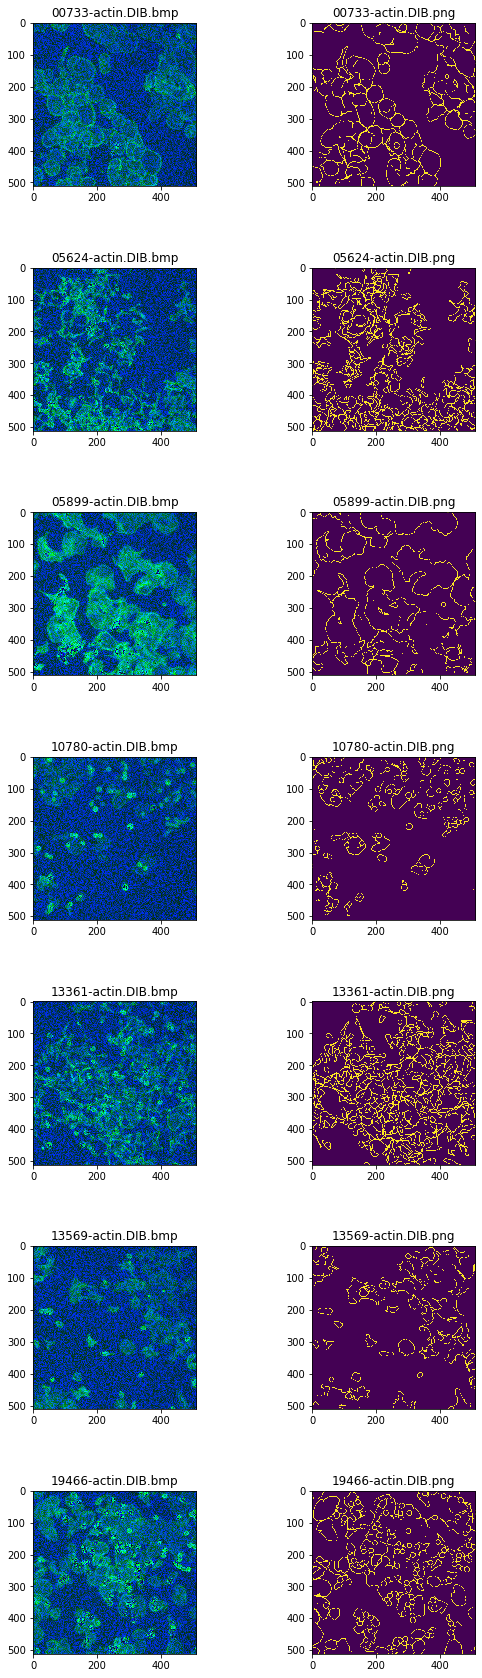

In [17]:
fig, ax = plt.subplots(7, 2, figsize=(10, 30), facecolor='w', edgecolor='k')
ax = ax.ravel()
fig.subplots_adjust(hspace = .5, wspace=.001)
test_imgs = sorted(os.listdir('BBBC018_v1_images-fixed/test/'))
test_imgs_folder = 'BBBC018_v1_images-fixed/test/'
test_imgs_mask_folder = 'TEST_PRED_LABELS/'

for i, name in enumerate(test_imgs):
    mask_name = name.split('.bmp')[0] + '.png'
    im = skimage.img_as_ubyte(skimage.io.imread(test_imgs_folder + name))
    predicted_mask = skimage.img_as_ubyte(skimage.io.imread(test_imgs_mask_folder + mask_name))
    ax[2*i].imshow(im)
    ax[2*i+1].imshow(predicted_mask)
    ax[2*i].set_title(name)
    ax[2*i+1].set_title(mask_name)

### Brief description of experiments

#### Architecture evolution

1. First I tried implementing vanilla UNet.
2. In the code I've seen, I noticed that people often use nearest neighbor interpolation instead of transpose convolution, and so I've changed it.
3. I listened a lecture by Vladimir Iglovikov in how they changed UNet feature extractor to the pretrained one, and added that to my implementation.

#### Evolution of data treatment

Here, most of my experiments concerned the batch size and image shape. I tried various image shapes like 
- 64x64
- 128x128
- 256x256
- 512x512
, and I was suprised that changing batch size didn't seem to help me a lot. What worked best, was using either the dimensions 128x128, 256x256 or 512x512, but the batch size didn't seem to change the convergence speed. Finally, I stayed with the 3 images in the batch of 512x512 size, with some simple augmentations like Flip (it is a random application of a horizontal or vertical flip) and a rotation of the image by 90, 180 or 270 degrees. Other augmentations seemed to slow down convergence a lot. In particular, I tried Elastric Transform and ToSepia and ToGray transformations from the `Albumentations` package.